In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install plot-metric

In [ ]:
!pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from plot_metric.functions import BinaryClassification

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
def read_input_data(INV_URL, INV_SHEET, INV_2024_URL, INV_2024_SHEET, ORDER_SHEET_1_URL, ORDER_SHEET_1_SHEET, ORDER_SHEET_2_URL, ORDER_SHEET_2_SHEET, OFFER_URL, OFFER_SHEET):
  spr = gc.open_by_url(INV_URL)
  wks = spr.worksheet(INV_SHEET)
  rows = wks.get_all_values()
  df_inv = pd.DataFrame.from_records(rows)
  df_inv = df_inv.rename(columns=df_inv.iloc[3]).iloc[4:].reset_index(drop = True)

  spr = gc.open_by_url(INV_2024_URL)
  wks = spr.worksheet(INV_2024_SHEET)
  rows = wks.get_all_values()
  df_inv_2024 = pd.DataFrame.from_records(rows)
  df_inv_2024 = df_inv_2024.rename(columns=df_inv_2024.iloc[3]).iloc[4:].reset_index(drop = True)

  spr = gc.open_by_url(ORDER_SHEET_1_URL)
  wks = spr.worksheet(ORDER_SHEET_1_SHEET)
  rows = wks.get_all_values()
  df_order_sheet1 = pd.DataFrame.from_records(rows)
  df_order_sheet1 = df_order_sheet1.rename(columns=df_order_sheet1.iloc[0]).iloc[1:].reset_index(drop = True)

  spr = gc.open_by_url(ORDER_SHEET_2_URL)
  wks = spr.worksheet(ORDER_SHEET_2_SHEET)
  rows = wks.get_all_values()
  df_order_sheet2 = pd.DataFrame.from_records(rows)
  df_order_sheet2 = df_order_sheet2.rename(columns=df_order_sheet2.iloc[0]).iloc[1:].reset_index(drop = True)

  spr = gc.open_by_url(OFFER_URL)
  wks = spr.worksheet(OFFER_SHEET)
  rows = wks.get_all_values()
  df_offer = pd.DataFrame.from_records(rows)
  df_offer = df_offer.rename(columns=df_offer.iloc[0]).iloc[1:].reset_index(drop = True)

  return df_inv, df_inv_2024, df_order_sheet1, df_order_sheet2, df_offer

In [ ]:
def append_inventory_from_sheets(df_inv, df_inv_2024):
  df_inv = df_inv.loc[:, [i for i in df_inv.columns if i != '']]
  df_inv = df_inv.rename(columns = {' Retail Price per Case (Local) ' : 'Retail Price per Case (Local)', ' Retail Price per Case (USD) ' : 'Retail Price per Case (USD)',
                          ' Asking Price per Case (Local) ' : 'Asking Price per Case (Local)', ' Asking Price per Case (USD) ' : 'Asking Price per Case (USD)'})
  df_inv = pd.concat([df_inv, df_inv_2024], ignore_index = True)
  return df_inv

In [ ]:
def column_rename(df, column_list):
  for i in column_list:
    new_col = i.lower().replace(' ', '_').replace('-', '_').replace('/', '_')
    if new_col != '':
      if new_col[0] == '_':
        new_col = new_col[1:]
      if new_col[-1] == '_':
        new_col = new_col[:-1]
    df.rename(columns = {i : new_col}, inplace = True)
  return df

def get_order_date(df_order_sheet1, df_order_sheet2):
  order_date_to_tracking_no_mapping = df_order_sheet1[['tracking_no', 'order_date']].drop_duplicates()
  df_order_sheet2 = pd.merge(df_order_sheet2, order_date_to_tracking_no_mapping, 'left',  on = ['tracking_no'])
  df_order_sheet2.drop('date_of_order', axis = 1, inplace = True)
  df_order = df_order_sheet2.copy()
  return df_order

In [ ]:
def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'pack_label_language', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

In [ ]:
def remove_old_cat_subcats(df_inv):
  df_inv = df_inv.drop(['old_product_category', 'old_product_subcategory'], axis = 1)
  return df_inv

In [ ]:
def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

In [ ]:
def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

In [ ]:
def print_status(df_inv, df_offer, df_order):
  print('Inv - ', df_inv.shape, 'Offer - ', df_offer.shape, 'Order - ', df_order.shape)
  print(df_order[(df_order.tracking_no.isnull()) | (df_order.expiry_date.isnull())].shape)

In [ ]:
def get_duplicate_count(df_inv, df_order):
  print('Inventory dups - ', df_inv.duplicated().sum())
  print('df_order dups on key - ', df_order[['sku_number', 'expiry_date', 'tracking_no']].duplicated().sum())

In [ ]:
def drop_dups_and_clean(df_inv, df_order):
  print('Dropping above duplicates ...')
  df_inv = df_inv.drop_duplicates()
  df_order = df_order.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
  return df_inv, df_order

In [ ]:
def get_priority_for_orders(x):
  return x.split(':')[0]

def get_priority_for_offers(x):
  return x.split('_')[0][1:3]

def get_recovery_rate_on_orders(df_order):
  df_order = df_order[~df_order['total_retail_price_(usd)'].isin(['', 'NA'])]
  df_order['total_retail_price_(usd)'] = df_order['total_retail_price_(usd)'].str.replace(',','').astype(float)
  df_order = df_order[df_order['total_retail_price_(usd)'] != 0]
  df_order['total_offer_price_(usd)'] = df_order['total_offer_price_(usd)'].str.replace(',', '').astype('float')
  df_order['recovery_rate'] = df_order['total_offer_price_(usd)'].astype('float') / df_order['total_retail_price_(usd)'].astype('float')
  return df_order

In [ ]:
def inv_dups_drop_plus_offer_status(df_inv, df_offer):
  print('Inv dups on a combo of sku, expiry, warehouse loc, updated_on -', df_inv.duplicated(subset = ['sku_number', 'earliest_expiry_date', 'warehouse_location', 'updated_on']).sum())
  df_inv = df_inv.drop_duplicates(subset = ['sku_number', 'earliest_expiry_date', 'warehouse_location', 'updated_on'])

  print('Offer shape - ', df_offer.shape)
  print('Offer dups - ', df_offer[['sku_number', 'expiry_date', 'tracking_no']].duplicated().sum())
  print('Duplicates on sku_number, expiry_date, tracking_no combos occuring due to different batch numbers')
  return df_inv

In [ ]:
def do_datatype_conversion(df_inv, df_offer, df_order):
  df_inv['total_units'] = df_inv['total_units'].str.replace(',', '')
  df_inv = df_inv[df_inv['total_units'] != '']
  df_inv['total_units'] = df_inv['total_units'].astype(float)
  df_inv = df_inv[~df_inv['expiry_date'].isin(['-', 'P1', 'P2', 'P3', 'MTO'])]
  df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])
  df_inv = df_inv[~df_inv.updated_on.isin(['20- Dec- 2023'])]
  df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])

  df_offer['total_units'] = df_offer['total_units'].str.replace(',', '')
  df_offer = df_offer[df_offer['total_units'] != '']
  df_offer['total_units'] = df_offer['total_units'].astype(float)
  df_offer = df_offer[df_offer['expiry_date'] != '-']
  df_offer['expiry_date'] = pd.to_datetime(df_offer['expiry_date'], format = "%d-%b-%Y")
  df_offer['date_of_offer'] = pd.to_datetime(df_offer['date_of_offer'])

  df_order = df_order[df_order['expiry_date'] != 'NA']
  df_order['expiry_date'] = pd.to_datetime(df_order['expiry_date'])
  df_order['total_units'] = df_order['total_units'].str.replace(',', '').astype(float)
  return df_inv, df_offer, df_order

In [ ]:
# the inventory updated in the last 14 days from today will be considered for test data. The remaining will be for train and val set. Also, generally we won't have
# offers for inventory updated / received in last 2 weeks around - it generally takes that much time to have offers against inventory line items. So, after left join
# those sellable inventory line items will also be labelled as 0 because of no offers against them

def filter_inventory_till_last_for_train_val_set(df_inv, filter_date):
  print('Inventory filtered till date for train and val - ', filter_date)
  df_inv = df_inv[df_inv.updated_on <= filter_date]
  return df_inv

In [ ]:
def inv_status(df_inv):
  print('Inv shape - ', df_inv.shape)

In [ ]:
# df_inv[df_inv['expiry_date'].isin(['-', 'P1', 'P2', 'P3', 'MTO'])]

In [ ]:
# try imputing to reduce data loss

def change_dtype(df, feat):
  # '', '-'
  df[feat] = df[feat].str.replace(' ', '').str.replace(',', '').str.replace('$', '').str.replace('%', '').str.replace('G', '')
  df = df[~df[feat].isin(['#DIV/0!', '$0.1000', '$0.67', '#VALUE!', '#N/A', 'Tube50g+Bottle50ml+Sachet5ml', 'Tube100mlSachet2x6mlBottle40ml',
                          'Bottle72mlTube48mlT12mlB40ml', '6x6x1mL', '22ML5.5ML', 'Sachet20gSachet20ml', 'Sachet20g+20ml', 'Sachet30g;30ml', 'Sachet-Sachet', '10x28g',
                           'Sachet20grSachet20ml', 'Tube100mlSachet2x6mlBotol40ml', '30X1.85', 'Tube50+Bottle50ml+Sachet5ml', '28g'])]
  df[feat] = df[feat].replace('', np.nan).replace('-', np.nan)
  df[feat] = df[feat].astype(float)
  return df

In [ ]:
def get_prev_inv_occurence_next_to_current(temp):
  new_col_names_for_shifted_inv = dict()
  for i in temp.columns:
    new_col_names_for_shifted_inv[i] = i+'_prev'

  temp_shifted = temp.shift(1)
  temp_shifted = temp_shifted.rename(columns = new_col_names_for_shifted_inv)
  temp = pd.concat([temp, temp_shifted], axis=1)
  return temp

def get_repeated_inv_and_mean_depletion(temp):
  repeated_inv = temp[(temp.sku_number == temp.sku_number_prev) & (temp.expiry_date == temp.expiry_date_prev) & (temp.seller == temp.seller_prev)]
  repeated_inv['depletion'] = repeated_inv['total_units_prev'] - repeated_inv['total_units']
  repeated_inv = repeated_inv.drop_duplicates(subset = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', \
                            'seller', 'updated_on'])[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller', 'updated_on', 'depletion']]
  brand_seller_depletion = repeated_inv.groupby(['brand', 'seller']).depletion.mean().reset_index()
  brand_seller_depletion.rename(columns = {'depletion' : 'brand_seller_depletion'}, inplace = True)

  product_category_seller_depletion = repeated_inv.groupby(['product_category', 'seller']).depletion.mean().reset_index()
  product_category_seller_depletion.rename(columns = {'depletion' : 'product_category_seller_depletion'}, inplace = True)

  product_subcategory_seller_depletion = repeated_inv.groupby(['product_subcategory', 'seller']).depletion.mean().reset_index()
  product_subcategory_seller_depletion.rename(columns = {'depletion' : 'product_subcategory_seller_depletion'}, inplace = True)

  sku_expiry_seller_depletion = repeated_inv.groupby(['sku_number', 'expiry_date', 'seller']).depletion.mean().reset_index()
  sku_expiry_seller_depletion.rename(columns = {'depletion' : 'sku_expiry_seller_depletion'}, inplace = True)

  return repeated_inv, brand_seller_depletion, product_category_seller_depletion, product_subcategory_seller_depletion, sku_expiry_seller_depletion

In [ ]:
def merge_inv_and_offer(df_inv, df_offer):
  df_inv = pd.merge(df_inv, df_offer[['sku_number', 'expiry_date', 'seller', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'offer_price_unit_(usd)']]
                    , 'left', on = ['sku_number', 'expiry_date', 'seller'])
  df_inv['offer_day_diff_updated_inv'] = (df_inv['date_of_offer'] - df_inv['updated_on']).dt.days
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv >= 0) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_min_offer_day_diff_updated_inv = df_inv.groupby(['sku_number', 'expiry_date', 'seller', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                      .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  df_inv = pd.merge(df_inv, df_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'expiry_date', 'seller', 'date_of_offer'])
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv == df_inv.min_offer_day_diff_updated_inv) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_inv.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return df_inv

In [ ]:
def get_target(df_inv):
  df_inv['sellability'] = np.where(df_inv.date_of_offer.isnull(), 0, 1)
  print(df_inv.sellability.value_counts())
  return df_inv

In [ ]:
def add_depletion_features(X_train, X_val, brand_seller_depletion, product_category_seller_depletion, product_subcategory_seller_depletion, sku_expiry_seller_depletion):
  X_train = pd.merge(X_train, sku_expiry_seller_depletion, 'left', on = ['sku_number', 'expiry_date', 'seller'])
  X_val = pd.merge(X_val, sku_expiry_seller_depletion, 'left', on = ['sku_number', 'expiry_date', 'seller'])
  X_train = pd.merge(X_train, brand_seller_depletion, 'left', on = ['brand', 'seller'])
  X_val = pd.merge(X_val, brand_seller_depletion, 'left', on = ['brand', 'seller'])
  X_train = pd.merge(X_train, product_category_seller_depletion, 'left', on = ['product_category', 'seller'])
  X_val = pd.merge(X_val, product_category_seller_depletion, 'left', on = ['product_category', 'seller'])
  X_train = pd.merge(X_train, product_subcategory_seller_depletion, 'left', on = ['product_subcategory', 'seller'])
  X_val = pd.merge(X_val, product_subcategory_seller_depletion, 'left', on = ['product_subcategory', 'seller'])
  return X_train, X_val

In [ ]:
def recovery_rate_statistic_calc(df_order, feat):
  x = df_order.groupby(feat).agg({'recovery_rate' : ['min', 'max', 'median', 'std']}).reset_index()
  y = df_order.groupby(feat).agg({'total_offer_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum'}).reset_index()
  y['mean_recovery_rate'] = y['total_offer_price_(usd)'] / y['total_retail_price_(usd)']
  y.drop(['total_offer_price_(usd)', 'total_retail_price_(usd)'], axis = 1, inplace = True)
  x.columns = x.columns.droplevel(level=0)
  x = x.rename(columns = {'' : feat, 'min' : 'min_RR_' + feat, 'max' : 'max_RR_' + feat, 'median' : 'median_RR_' + feat, 'std' : 'std_RR_' + feat})
  x = pd.merge(x, y, 'left', on = feat)
  x = x.rename(columns = {'mean_recovery_rate' : 'mean_RR_' + feat})
  return x

In [ ]:
def get_recovery_rates_from_orders(X_train, X_val, df_order, get_RR_stats_of_these_cols):
  feat_to_RR_stats_mapping = dict()
  for feat in get_RR_stats_of_these_cols:
    feat_to_RR_stats_mapping[feat] = recovery_rate_statistic_calc(df_order[df_order.is_train == 1], feat)
    feat_to_RR_stats_mapping[feat][feat] = feat_to_RR_stats_mapping[feat][feat].str.lower()
    X_train = pd.merge(X_train, feat_to_RR_stats_mapping[feat], 'left', on = feat)
    X_val = pd.merge(X_val, feat_to_RR_stats_mapping[feat], 'left', on = feat)
  return feat_to_RR_stats_mapping, X_train, X_val

In [ ]:
def compute_and_impute_sell_thru_rates(X_train, X_val, units_ordered_df):
  X_train = pd.merge(X_train, units_ordered_df, 'left', on = ['sku_number', 'expiry_date', 'tracking_no'])
  X_train['total_units_ordered'] = X_train['total_units_ordered'].fillna(0)
  X_val = pd.merge(X_val, units_ordered_df, 'left', on = ['sku_number', 'expiry_date', 'tracking_no'])
  X_val['total_units_ordered'] = X_val['total_units_ordered'].fillna(0)
  X_train['sell_thru_rate'] = X_train['total_units_ordered'] / X_train['total_units']
  X_val['sell_thru_rate'] = X_val['total_units_ordered'] / X_val['total_units']
  X_train['sell_thru_rate'] = np.where(X_train['sell_thru_rate'] > 1, 1, X_train['sell_thru_rate'])
  X_val['sell_thru_rate'] = np.where(X_val['sell_thru_rate'] > 1, 1, X_val['sell_thru_rate'])
  return X_train, X_val

In [ ]:
def get_combination_feats(df):
  df['sku_plus_priority'] = df.sku_number.astype('str') + '_' + df.priority_order.astype('str')
  df['seller_plus_priority'] = df.seller.astype('str') + '_' + df.priority_order.astype('str')
  df['brand_plus_priority'] = df['brand'].astype('str') + '_' + df.priority_order.astype('str')
  df['product_category_plus_priority'] = df['product_category'].astype('str') + '_' + df.priority_order.astype('str')
  return df

In [ ]:
def sell_thru_rate_statistic_calc(X_train, feat):
  x = X_train.groupby(feat).agg({'sell_thru_rate' : ['min', 'max', 'median', 'std']}).reset_index()
  y = X_train.groupby(feat).agg({'total_units_ordered' : 'sum', 'total_units' : 'sum'}).reset_index()
  y['mean_sell_thru_rate'] = y['total_units_ordered'] / y['total_units']
  y.drop(['total_units_ordered', 'total_units'], axis = 1, inplace = True)
  x.columns = x.columns.droplevel(level=0)
  x = x.rename(columns = {'' : feat, 'min' : 'min_SR_' + feat, 'max' : 'max_SR_' + feat, 'median' : 'median_SR_' + feat, 'std' : 'std_SR_' + feat})
  x = pd.merge(x, y, 'left', on = feat)
  x = x.rename(columns = {'mean_sell_thru_rate' : 'mean_SR_' + feat})
  return x

In [ ]:
def get_sell_thru_rates(X_train, X_val, get_SR_stats_of_these_cols):
  feat_to_SR_stats_mapping = dict()
  for feat in get_SR_stats_of_these_cols:
    feat_to_SR_stats_mapping[feat] = sell_thru_rate_statistic_calc(X_train, feat)
    feat_to_SR_stats_mapping[feat][feat] = feat_to_SR_stats_mapping[feat][feat].str.lower()
    X_train = pd.merge(X_train, feat_to_SR_stats_mapping[feat], 'left', on = feat)
    X_val = pd.merge(X_val, feat_to_SR_stats_mapping[feat], 'left', on = feat)
  return feat_to_SR_stats_mapping, X_train, X_val

In [ ]:
def drop_more_cols_from_train_cols(X_train, X_val):
  X_train.drop(['tracking_no', 'expiry_date', 'total_units_ordered', 'sell_thru_rate'], axis = 1, inplace = True)
  X_val.drop(['tracking_no', 'expiry_date', 'total_units_ordered', 'sell_thru_rate'], axis = 1, inplace = True)
  return X_train, X_val

In [ ]:
def get_cat_cols_and_nums_cols(X_train):
  cat_cols = []
  num_cols = []
  for col in X_train.columns:
    if X_train[col].dtype == 'object':
      cat_cols.append(col)
    else:
      num_cols.append(col)
  return cat_cols, num_cols

In [ ]:
def get_unique_list_of_sku_attributes_train_set(X_train):
  train_sku_number_list = list(X_train['sku_number'].unique())
  train_brand_list = list(X_train['brand'].unique())
  train_product_category_list = list(X_train['product_category'].unique())
  train_product_sub_category_list = list(X_train['product_subcategory'].unique())
  return train_sku_number_list, train_brand_list, train_product_category_list, train_product_sub_category_list

In [ ]:
# get record data

def get_product_records(df_inv, record_attributes):
  df_inv['retail_price_per_unit_local'] = df_inv['total_retail_price_(local)'] / df_inv['total_units']
  record_attributes.remove('sku_name')
  df_record = df_inv[record_attributes + ['sellability']]
  df_record['currency'] = df_record['currency'].replace('_thb_', 'thb')
  df_record['brand'] = df_record['brand'].replace('love_beauty_and_planet', 'love_beauty_&_planet')
  return df_inv, df_record

def get_product_record_categorical_encodings(df_record):
  sku_number_mapping = df_record.groupby('sku_number').agg({'sellability' : 'mean'}).reset_index().rename(columns = {'sellability' : 'sku_number_encoding'})
  sku_number_mapping = dict(zip(list(sku_number_mapping.sku_number), list(sku_number_mapping.sku_number_encoding)))
  brand_mapping = df_record.groupby('brand').agg({'sellability' : 'mean'}).reset_index().rename(columns = {'sellability' : 'brand_encoding'})
  brand_mapping = dict(zip(list(brand_mapping.brand), list(brand_mapping.brand_encoding)))
  product_category_mapping = df_record.groupby('product_category').agg({'sellability' : 'mean'}).reset_index()\
                                        .rename(columns = {'sellability' : 'product_category_encoding'})
  product_category_mapping = dict(zip(list(product_category_mapping.product_category),\
                                           list(product_category_mapping.product_category_encoding)))
  product_subcategory_mapping = df_record.groupby('product_subcategory').agg({'sellability' : 'mean'}).\
                                      reset_index().rename(columns = {'sellability' : 'product_subcategory_encoding'})
  product_subcategory_mapping = dict(zip(list(product_subcategory_mapping.product_subcategory), \
                                              list(product_subcategory_mapping.product_subcategory_encoding)))
  currency_mapping = df_record.groupby('currency').agg({'sellability' : 'mean'}).\
                                      reset_index().rename(columns = {'sellability' : 'currency_encoding'})
  currency_mapping = dict(zip(list(currency_mapping.currency), list(currency_mapping.currency_encoding)))

  return sku_number_mapping, brand_mapping, product_category_mapping, product_subcategory_mapping, currency_mapping

def apply_product_record_mappings(df_record, sku_number_mapping, brand_mapping, product_category_mapping, product_subcategory_mapping, currency_mapping):
  df_record['sku_number'] = df_record['sku_number'].map(sku_number_mapping)
  df_record['brand'] = df_record['brand'].map(brand_mapping)
  df_record['product_category'] = df_record['product_category'].map(product_category_mapping)
  df_record['product_subcategory'] = df_record['product_subcategory'].map(product_subcategory_mapping)
  df_record['currency'] = df_record['currency'].map(currency_mapping)
  return df_record

In [ ]:
# def remove_inv_dups_from_train_and_val_set(X_train, X_val, y_train, y_val):
#   X_train['is_train'] = 1
#   X_val['is_train'] = 0
#   temp_df = pd.concat([X_train, X_val], ignore_index=True)
#   temp_target = pd.concat([y_train, y_val], ignore_index=True)
#   temp_df['target'] = temp_target
#   temp_df = temp_df.drop_duplicates(subset = ['updated_on', 'sku_number', 'expiry_date', 'seller'])
#   X_train = temp_df[temp_df.is_train == 1]
#   y_train = X_train.target
#   X_val = temp_df[temp_df.is_train == 0]
#   y_val = X_val.target
#   X_train.drop(['updated_on', 'expiry_date', 'is_train', 'target'], axis = 1, inplace = True)
#   X_val.drop(['updated_on', 'expiry_date', 'is_train', 'target'], axis = 1, inplace = True)

#   return X_train, X_val, y_train, y_val


In [ ]:
# # removing duplicates like same inventory line item but multiple offers and tracking_nos against them. Didn't remove before because we need all offers and orders
# # to calculate RRs and SRs accurately. Same rows present in train and test would make us infer model performance in a bad way. Hence drop those dups

def remove_same_samples_from_train_in_val(X_train, X_val, y_val):
  X_val['target'] = y_val.reset_index(drop = True)
  X_val = pd.merge(X_val, X_train[['updated_on', 'seller', 'sku_number', 'expiry_date']], 'left', \
                  on = ['updated_on', 'seller', 'sku_number', 'expiry_date'], indicator = True)
  X_val = X_val[X_val['_merge'] == 'left_only']
  y_val = X_val.target.reset_index(drop = True)
  X_val.drop(['_merge', 'target'], axis = 1, inplace = True)
  return X_val, y_val

In [ ]:
def train_catboost(X_train, y_train, X_val, y_val, cat_features, params, iterations = 300, eval_metric = 'Precision', random_state = 7, auto_class_weights = None):
  model = CatBoostClassifier(**params, iterations = iterations, eval_metric = eval_metric, random_state = random_state, auto_class_weights = auto_class_weights)
  model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=True)
  return model

In [ ]:
# calculate shap values also

def plot_feature_importances(model, X_train):
  importances = model.get_feature_importance()
  feature_importances = pd.Series(importances, index = X_train.columns).sort_values()

  plt.figure(figsize=(10,17))
  plt.barh(feature_importances.index, feature_importances.values)
  plt.title('CatBoost Feature Importance')
  plt.xlabel('Importance')
  plt.ylabel('Features')
  plt.show()
  feature_importances = feature_importances.sort_values(ascending = False)
  return feature_importances

In [ ]:
# tune the threshold

def plot_mterics_report(y_val, pred_probs, t):
  bc = BinaryClassification(y_val, pred_probs[:, 1], labels=["Not Sellable", "Sellable"])

  # Figures
  plt.figure(figsize=(15,10))
  plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
  bc.plot_roc_curve(threshold = t)
  plt.subplot2grid((2,6), (0,2), colspan=2)
  bc.plot_precision_recall_curve(threshold = t)
  plt.subplot2grid((2,6), (0,4), colspan=2)
  bc.plot_class_distribution(pal_colors=['r','g','m','k'], threshold = t)
  plt.subplot2grid((2,6), (1,1), colspan=2)
  a = bc.plot_confusion_matrix(threshold = t)

  plt.show()
  bc.print_report(threshold = t)

In [ ]:
INV_URL = 'https://docs.google.com/spreadsheets/d/1N1SPW166_GFoCChWZY-KTg8-t40EaqiAAKRHdliY1Es/edit#gid=1652280687'
INV_SHEET = 'Consolidation 2023 & 2024'
INV_2024_URL = 'https://docs.google.com/spreadsheets/d/1N1SPW166_GFoCChWZY-KTg8-t40EaqiAAKRHdliY1Es/edit#gid=290771326'
INV_2024_SHEET = 'Consolidation 2024'
ORDER_SHEET_1_URL = 'https://docs.google.com/spreadsheets/d/1iIQK5HQAk0WchVvEAVQlCoQr9wlFGTU0j_LPE9wtDoA/edit#gid=1276595272'
ORDER_SHEET_1_SHEET = 'Orders_Level 01'
ORDER_SHEET_2_URL = 'https://docs.google.com/spreadsheets/d/1iIQK5HQAk0WchVvEAVQlCoQr9wlFGTU0j_LPE9wtDoA/edit#gid=1092414161'
ORDER_SHEET_2_SHEET = 'Orders_Level 02'
OFFER_URL = 'https://docs.google.com/spreadsheets/d/113FPteQQhW-YmPSuok57AVdOFM4D0lSSwKp22Z5mA7E/edit#gid=977984480'
OFFER_SHEET = 'Offers Breakdown'

cols_list_underscore_cleaning = ['sku_name', 'product_name', 'package_type', 'brand', 'product_category', 'product_subcategory', 'warehouse_location', 'country',
            'country_of_origin', 'pack_label_language', 'product_restricted_countries', 'shelf_life_bucket']

inv_cols_list_to_change_dtypes = ['qty_of_cartons', 'units_per_cartons', 'retail_price_per_case_(local)', 'retail_price_per_case_(usd)', 'asking_price_per_case_(local)',
                              'asking_price_per_case_(usd)', 'total_retail_price_(local)', 'total_retail_price_(usd)', 'total_asking_price_(local)',
                              'total_asking_price_(usd)', 'pack_size_(number)', 'total_cbm', 'cbm_per_case', 'package_dimensions_per_package_type_(length)',
                              'package_dimensions_per_case_(width)', 'package_dimensions_per_case_(height)', 'net_weight_\nper_unit(kg)', 'net_weight_per_case_(kg)',
                              'gross_weight_per_case_(kg)', 'total_net_weight_(kg)', 'total_gross_weight_(kg)', 'cases_per_pallet', 'number_of_pallets', 'discount',
                              'shelf_remaining_days']

offer_cols_list_to_change_dtypes = ['offered_qty_(cartons)', 'units_per_carton', 'retail_price_unit_(usd)', 'retail_price_carton_(usd)', 'total_retail_price_(usd)',
                                    'asking_price_carton_(usd)', 'total_asking_price_(usd)', 'total_offer_price_(usd)',
                                    'gross_weight_package_type_(kg)', 'total_gross_weight_(kg)', 'cbm_package_type', 'recovery_rate_(retail)', 'recovery_rate_(asking)',
                                    'discount_%', 'offer_price_unit_(usd)']

cols_to_remove_from_train = ['bar_code_format_(ean_upc)', 'bar_code_number', 'manufactured_date', 'msds_file_(y_n)',
                             'minimum_accepted_price_per_carton_(local_currency)', 'minimum_accepted_price_per_carton_(usd)',
                             'total_minimum_asking_price_(local_currency)', 'total_minimum_price_(usd)', 'inventory_classification', 'latest_vs_archive',
                             'correct_vs_incorrect', 'date_of_offer', 'actual', 'offer_day_diff_updated_inv', 'sellability', 'buyer']

get_RR_stats_of_these_cols = ['brand', 'product_category', 'product_subcategory', 'priority_order']

get_SR_stats_of_these_cols = ['seller', 'brand', 'priority_order', 'product_category', 'product_subcategory', 'seller_plus_priority', 'brand_plus_priority',
                              'product_category_plus_priority']

listing_model_params = {'loss_function': 'Logloss',
          'od_wait' : 100,
          'learning_rate': 0.2,
          'colsample_bylevel': 0.6,
          'depth': 4,
          'min_data_in_leaf': 35,
          'subsample': 0.6,
          'custom_metric' : 'AUC:hints=skip_train~false'}

record_attributes = ['sku_number', 'sku_name', 'brand', 'product_category', 'product_subcategory', 'retail_price_per_unit_local', 'currency']

n_days_before_date = pd.to_datetime(date.today() - timedelta(days = 14))

THRESHOLD = 0.6

In [ ]:
print(n_days_before_date)

2024-11-01 00:00:00


In [ ]:
def main():
  df_inv, df_inv_2024, df_order_sheet1, df_order_sheet2, df_offer = read_input_data(INV_URL, INV_SHEET, INV_2024_URL, INV_2024_SHEET, ORDER_SHEET_1_URL, ORDER_SHEET_1_SHEET, ORDER_SHEET_2_URL,
                                                                     ORDER_SHEET_2_SHEET, OFFER_URL, OFFER_SHEET)

  # return df_inv, df_inv_2024

  df_inv = append_inventory_from_sheets(df_inv, df_inv_2024)

  df_inv = column_rename(df_inv, df_inv.columns)
  df_order_sheet1 = column_rename(df_order_sheet1, df_order_sheet1.columns)
  df_order_sheet2 = column_rename(df_order_sheet2, df_order_sheet2.columns)
  df_offer = column_rename(df_offer, df_offer.columns)

  df_order = get_order_date(df_order_sheet1, df_order_sheet2)

  df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)
  df_offer = cols_to_lower_rem_space(df_offer, df_offer.columns)
  df_order = cols_to_lower_rem_space(df_order, df_order.columns)

  df_inv = remove_old_cat_subcats(df_inv)

  print(df_inv.shape, df_offer.shape, df_order.shape)

  df_inv = cleaning_underscores_inv_data(df_inv, cols_list_underscore_cleaning)

  print_status(df_inv, df_offer, df_order)
  get_duplicate_count(df_inv, df_order)
  df_inv, df_order = drop_dups_and_clean(df_inv, df_order)

  df_order['priority_order'] = df_order['priority'].apply(get_priority_for_orders)
  df_offer['shelf_life_bucket'] = df_offer.shelf_life_bucket.astype(str)
  df_offer['priority_order'] = df_offer.shelf_life_bucket.apply(get_priority_for_offers)

  df_order = get_recovery_rate_on_orders(df_order)
  df_inv['priority_order'] = df_inv.shelf_life_bucket.apply(get_priority_for_offers)

  df_inv = inv_dups_drop_plus_offer_status(df_inv, df_offer)

  df_inv['store_name'] = df_inv['store_name'].str.replace('_', '')
  df_inv = df_inv.rename(columns = {'earliest_expiry_date' : 'expiry_date', 'store_name' : 'seller'})
  df_offer = df_offer.rename(columns = {'deal_type' : 'domestic_export', 'brand_' : 'brand', 'origin' : 'origin_inv'})

  df_inv, df_offer, df_order = do_datatype_conversion(df_inv, df_offer, df_order)

  df_inv = filter_inventory_till_last_for_train_val_set(df_inv, filter_date = n_days_before_date)

  inv_status(df_inv)

  for feat in inv_cols_list_to_change_dtypes:
    df_inv = change_dtype(df_inv, feat)

  for feat in offer_cols_list_to_change_dtypes:
    df_offer = change_dtype(df_offer, feat)

  # ideally add rows with following combination - different warehouse location existing
  df_inv = df_inv.drop_duplicates(subset = ['updated_on', 'sku_number', 'expiry_date', 'seller'])


  temp = df_inv[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller', 'updated_on', 'total_units']]\
                    .sort_values(by = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller', 'updated_on'])
  temp = temp.reset_index(drop = True)
  temp = get_prev_inv_occurence_next_to_current(temp)
  repeated_inv, brand_seller_depletion, product_category_seller_depletion, product_subcategory_seller_depletion, sku_expiry_seller_depletion = get_repeated_inv_and_mean_depletion(temp)

  inv_status(df_inv)
  df_inv = merge_inv_and_offer(df_inv, df_offer)
  inv_status(df_inv)

  # removing pollen save offers from pollen direct
  df_inv = df_inv[~df_inv['buyer'].str.contains('pollen_save', na=False)]

  df_inv = get_target(df_inv)

  train_cols = [col for col in df_inv.columns if col not in cols_to_remove_from_train]

  # stratification on seller + sellability combo
  df_inv['seller_sellabilty'] = df_inv['seller'].astype('str') + '_' + df_inv['sellability'].astype('str')

  X_train, X_val, y_train, y_val = train_test_split(df_inv[train_cols], df_inv['sellability'], stratify=df_inv['seller_sellabilty'], test_size=0.2, random_state = 7)

  X_train, X_val = add_depletion_features(X_train, X_val, brand_seller_depletion, product_category_seller_depletion, product_subcategory_seller_depletion, sku_expiry_seller_depletion)

  df_order['is_train'] = np.where(df_order.tracking_no.isin(X_train.tracking_no), 1, 0)

  df_order = df_order.rename(columns = {'product_sub_category' : 'product_subcategory'})
  feat_to_RR_stats_mapping, X_train, X_val = get_recovery_rates_from_orders(X_train, X_val, df_order, get_RR_stats_of_these_cols)

  units_ordered_df = df_order[['sku_number', 'expiry_date', 'tracking_no', 'total_units']].drop_duplicates()
  units_ordered_df = units_ordered_df.rename(columns = {'total_units' : 'total_units_ordered'})

  X_train, X_val = compute_and_impute_sell_thru_rates(X_train, X_val, units_ordered_df)

  X_train = get_combination_feats(X_train)
  X_val = get_combination_feats(X_val)

  feat_to_SR_stats_mapping, X_train, X_val = get_sell_thru_rates(X_train, X_val, get_SR_stats_of_these_cols)

  print(X_train.shape, X_val.shape)

  train_sku_number_list, train_brand_list, train_product_category_list, train_product_sub_category_list = get_unique_list_of_sku_attributes_train_set(X_train)

  # X_train, X_val, y_train, y_val = remove_inv_dups_from_train_and_val_set(X_train, X_val, y_train, y_val)

  # return X_val, y_val

  X_val, y_val = remove_same_samples_from_train_in_val(X_train, X_val, y_val)

  print(X_train.shape, X_val.shape)

  X_train = X_train.drop(['updated_on', 'expiry_date', 'tracking_no', 'total_units_ordered', 'sell_thru_rate'], axis = 1)
  X_val = X_val.drop(['updated_on', 'expiry_date', 'tracking_no', 'total_units_ordered', 'sell_thru_rate'], axis = 1)

  cat_cols, num_cols = get_cat_cols_and_nums_cols(X_train)

  final_train_cols = list(X_train.columns)

  # get product records and encode them

  df_inv, df_record = get_product_records(df_inv, record_attributes)
  sku_number_mapping, brand_mapping, product_category_mapping, product_subcategory_mapping,\
                          currency_mapping = get_product_record_categorical_encodings(df_record)
  df_record = apply_product_record_mappings(df_record, sku_number_mapping, brand_mapping, product_category_mapping, product_subcategory_mapping,\
                                            currency_mapping)

  return df_inv, X_train, y_train, X_val, y_val, cat_cols, feat_to_RR_stats_mapping, feat_to_SR_stats_mapping, final_train_cols, train_sku_number_list, train_brand_list,\
          train_product_category_list, train_product_sub_category_list, cat_cols, num_cols, n_days_before_date, df_record, sku_number_mapping, brand_mapping,\
          product_category_mapping, product_subcategory_mapping,currency_mapping, brand_seller_depletion, product_category_seller_depletion,\
          product_subcategory_seller_depletion, sku_expiry_seller_depletion

  # training listing level model

  # model = train_catboost(X_train, y_train, X_val, y_val, cat_cols, listing_model_params, iterations = 500, eval_metric = 'Precision', random_state = 7, auto_class_weights = 'Balanced')
  # pred_probs = model.predict_proba(X_val.values)
  # feature_importances = plot_feature_importances(model, X_train)
  # plot_mterics_report(y_val, pred_probs, t = THRESHOLD)

  # return feat_to_RR_stats_mapping, feat_to_SR_stats_mapping, final_train_cols, X_train, X_val, y_train, y_val, train_sku_number_list, train_brand_list,\
  #         train_product_category_list, train_product_sub_category_list, cat_cols, num_cols, n_days_before_date, model, df_record, sku_number_mapping, brand_mapping,\
  #         product_category_mapping, product_subcategory_mapping,currency_mapping, brand_seller_depletion, product_category_seller_depletion,\
  #         product_subcategory_seller_depletion, sku_expiry_seller_depletion

In [ ]:
df_inv, X_train, y_train, X_val, y_val, cat_cols, feat_to_RR_stats_mapping, feat_to_SR_stats_mapping, final_train_cols, train_sku_number_list, train_brand_list,\
          train_product_category_list, train_product_sub_category_list, cat_cols, num_cols, n_days_before_date, df_record, sku_number_mapping, brand_mapping,\
          product_category_mapping, product_subcategory_mapping,currency_mapping, brand_seller_depletion, product_category_seller_depletion,\
          product_subcategory_seller_depletion, sku_expiry_seller_depletion = main()

(37934, 58) (17065, 59) (9072, 38)
Inv -  (37934, 58) Offer -  (17065, 59) Order -  (9072, 38)
(0, 38)
Inventory dups -  404
df_order dups on key -  4819
Dropping above duplicates ...
Inv dups on a combo of sku, expiry, warehouse loc, updated_on - 614
Offer shape -  (17065, 60)
Offer dups -  1878
Duplicates on sku_number, expiry_date, tracking_no combos occuring due to different batch numbers
Inventory filtered till date for train and val -  2024-11-01 00:00:00
Inv shape -  (33511, 59)
Inv shape -  (31976, 59)
Inv shape -  (29491, 65)
sellability
0    21395
1     7745
Name: count, dtype: int64
(23312, 120) (5828, 120)
(23312, 120) (5130, 120)


In [ ]:
# X_train = X_train.drop('offer_price_unit_(usd)', axis = 1)
# X_val = X_val.drop('offer_price_unit_(usd)', axis = 1)
# final_train_cols.remove('offer_price_unit_(usd)')

# Execute following cluster of code only if scores at multiple prices points is required

In [ ]:
y_train = y_train.reset_index(drop = True)
X_train['sellability'] = y_train
y_val = y_val.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_val['sellability'] = y_val

In [ ]:
X_train['retail_price_per_unit_usd'] = X_train['total_retail_price_(usd)'] / X_train['total_units']
X_val['retail_price_per_unit_usd'] = X_val['total_retail_price_(usd)'] / X_val['total_units']

X_train['asking_price_per_unit_usd'] = X_train['total_asking_price_(usd)'] / X_train['total_units']
X_val['asking_price_per_unit_usd'] = X_val['total_asking_price_(usd)'] / X_val['total_units']

temp = X_train['offer_price_unit_(usd)']
X_train = X_train.drop('offer_price_unit_(usd)', axis = 1)
X_train['offer_price_unit_(usd)'] = temp

temp = X_val['offer_price_unit_(usd)']
X_val = X_val.drop('offer_price_unit_(usd)', axis = 1)
X_val['offer_price_unit_(usd)'] = temp

In [ ]:
def get_val_prices(df):
  if pd.isna(df['offer_price_unit_(usd)']):
    return np.random.uniform(low = 0, high = df['retail_price_per_unit_usd'], size = (1,))[0]
  else:
    return df['offer_price_unit_(usd)']

In [ ]:
X_val['offer_price_unit_(usd)'] = X_val.apply(get_val_prices, axis = 1)

In [ ]:
deals_df = X_train[X_train.sellability == 1]
no_deals_df = X_train[X_train.sellability == 0]
deals_df_copy = deals_df.copy()

In [ ]:
def get_prices(df):
  if pd.isna(df['offer_price_unit_(usd)']):
    return np.random.uniform(low = 0, high = df['retail_price_per_unit_usd'], size = (2,))
  else:
    return np.random.uniform(low = df['offer_price_unit_(usd)'], high = df['retail_price_per_unit_usd'], size = (2,))

In [ ]:
deals_df['test_price_usd'] = deals_df.apply(get_prices, axis = 1)
no_deals_df['test_price_usd'] = no_deals_df.apply(get_prices, axis = 1)

In [ ]:
deals_df = deals_df.explode('test_price_usd')
deals_df['sellability'] = 0

no_deals_df = no_deals_df.explode('test_price_usd')

deals_df['offer_price_unit_(usd)'] = deals_df['test_price_usd']
no_deals_df['offer_price_unit_(usd)'] = no_deals_df['test_price_usd']

In [ ]:
deals_df = pd.concat([deals_df, no_deals_df], ignore_index=True)
deals_df = deals_df.drop('test_price_usd', axis = 1)
X_train = pd.concat([deals_df_copy, deals_df], ignore_index=True)

In [ ]:
y_train = X_train['sellability']
X_train = X_train.drop('sellability', axis = 1)

In [ ]:
y_val = X_val['sellability']
X_val = X_val.drop('sellability', axis = 1)

In [ ]:
final_train_cols = list(X_train.columns)

In [ ]:
X_train

,seller,sku_number,sku_name,product_name,package_type,qty_of_cartons,units_per_cartons,total_units,currency,retail_price_per_case_(local),retail_price_per_case_(usd),asking_price_per_case_(local),asking_price_per_case_(usd),total_retail_price_(local),total_retail_price_(usd),total_asking_price_(local),total_asking_price_(usd),pack_size_(number),pack_size_(unit),brand,product_category,product_subcategory,total_cbm,cbm_per_case,package_dimensions_per_package_type_(length),package_dimensions_per_case_(width),package_dimensions_per_case_(height),unit_(case),net_weight_\nper_unit(kg),net_weight_per_case_(kg),gross_weight_per_case_(kg),total_net_weight_(kg),total_gross_weight_(kg),cases_per_pallet,number_of_pallets,warehouse_location,country,country_of_origin,pack_label_language,dangerous_goods\n(y_n),product_restricted_countries,discount,shelf_remaining_days,shelf_life_bucket,relavant_(r)_ir_relavant(ir),priority_order,sku_expiry_seller_depletion,brand_seller_depletion,product_category_seller_depletion,product_subcategory_seller_depletion,min_RR_brand,max_RR_brand,median_RR_brand,std_RR_brand,mean_RR_brand,min_RR_product_category,max_RR_product_category,median_RR_product_category,std_RR_product_category,mean_RR_product_category,min_RR_product_subcategory,max_RR_product_subcategory,median_RR_product_subcategory,std_RR_product_subcategory,mean_RR_product_subcategory,min_RR_priority_order,max_RR_priority_order,median_RR_priority_order,std_RR_priority_order,mean_RR_priority_order,sku_plus_priority,seller_plus_priority,brand_plus_priority,product_category_plus_priority,min_SR_seller,max_SR_seller,median_SR_seller,std_SR_seller,mean_SR_seller,min_SR_brand,max_SR_brand,median_SR_brand,std_SR_brand,mean_SR_brand,min_SR_priority_order,max_SR_priority_order,median_SR_priority_order,std_SR_priority_order,mean_SR_priority_order,min_SR_product_category,max_SR_product_category,median_SR_product_category,std_SR_product_category,mean_SR_product_category,min_SR_product_subcategory,max_SR_product_subcategory,median_SR_product_subcategory,std_SR_product_subcategory,mean_SR_product_subcategory,min_SR_seller_plus_priority,max_SR_seller_plus_priority,median_SR_seller_plus_priority,std_SR_seller_plus_priority,mean_SR_seller_plus_priority,min_SR_brand_plus_priority,max_SR_brand_plus_priority,median_SR_brand_plus_priority,std_SR_brand_plus_priority,mean_SR_brand_plus_priority,min_SR_product_category_plus_priority,max_SR_product_category_plus_priority,median_SR_product_category_plus_priority,std_SR_product_category_plus_priority,mean_SR_product_category_plus_priority,retail_price_per_unit_usd,asking_price_per_unit_usd,offer_price_unit_(usd)
0,lomy,G4111801,els_exo_shp_620ml_ebt_pcr,els_exo_shp_620ml_ebt_pcr,carton,79.00,6.0,474.0,myr,204.48,46.72,81.79,18.69,16153.92,3691.06,6461.57,1476.42,NaN,-,l'oreal_paris,hair_care,hair_care_-_others,94.95,1.20,52.0,91.0,254.0,MM,0.71,NaN,4.24,NaN,335.12,NaN,NaN,sarawak,malaysia,-,-,-,-,60.00,424.0,(p3)_>1_year,,p3,0.0,53.437971,76.428386,20.250278,0.006703,0.916937,0.165572,0.110460,0.144715,0.022834,0.916937,0.171718,0.116201,0.184651,0.034258,0.580211,0.214400,0.094779,0.196186,0.006703,0.939520,0.165187,0.112753,0.161414,G4111801_p3,lomy_p3,l'oreal_paris_p3,hair_care_p3,0.0,1.0,0.0,0.117116,0.062977,0.0,1.0,0.0,0.279145,0.052719,0.0,1.0,0.0,0.245959,0.109171,0.0,1.0,0.0,0.259820,0.090286,0.0,1.0,0.0,0.255269,0.022388,0.0,1.0,0.0,0.117946,0.074868,0.0,1.0,0.0,0.291503,0.131367,0.0,1.0,0.0,0.269550,0.121575,7.787046,3.114810,0.6
1,loth,G4197200,rv_pro_retinol_serum_7.5ml_as_os,rv_pro_retinol_serum_7.5ml_as_os,carton,222.46,180.0,40043.0,thb,29520.00,851.21,3751.68,108.18,6567052.00,189361.40,834601.82,24065.80,10.0,G,l'oreal_paris,skin_care,serums_&_treatments,1.14,0.01,220.0,172.0,136.0,MM,0.01,1.97,1.97,437.80,437.80,217.0,1.03,l'oréal_thailand_distribution_center,thailand,cn,th,0,-,87.29,189.0,(p2)_6-12_months,R,p2,NaN,216.737705,467.324834,544.107383,0.006703,0.916937,0.165572,0.110460,0.144715,0.008414,0.652365,

#training

0:	learn: 0.7700672	test: 0.8868451	best: 0.8868451 (0)	total: 136ms	remaining: 1m 8s
1:	learn: 0.7109281	test: 0.9006252	best: 0.9006252 (1)	total: 267ms	remaining: 1m 6s
2:	learn: 0.7536134	test: 0.9152850	best: 0.9152850 (2)	total: 381ms	remaining: 1m 3s
3:	learn: 0.7794704	test: 0.9249213	best: 0.9249213 (3)	total: 532ms	remaining: 1m 6s
4:	learn: 0.7740572	test: 0.9309191	best: 0.9309191 (4)	total: 651ms	remaining: 1m 4s
5:	learn: 0.7797261	test: 0.9335969	best: 0.9335969 (5)	total: 770ms	remaining: 1m 3s
6:	learn: 0.7732272	test: 0.9327713	best: 0.9335969 (5)	total: 898ms	remaining: 1m 3s
7:	learn: 0.8016163	test: 0.9358099	best: 0.9358099 (7)	total: 1s	remaining: 1m 1s
8:	learn: 0.8004919	test: 0.9351200	best: 0.9358099 (7)	total: 1.14s	remaining: 1m 2s
9:	learn: 0.8068372	test: 0.9376059	best: 0.9376059 (9)	total: 1.28s	remaining: 1m 2s
10:	learn: 0.8123092	test: 0.9389780	best: 0.9389780 (10)	total: 1.4s	remaining: 1m 2s
11:	learn: 0.8154572	test: 0.9397680	best: 0.9397680 (11

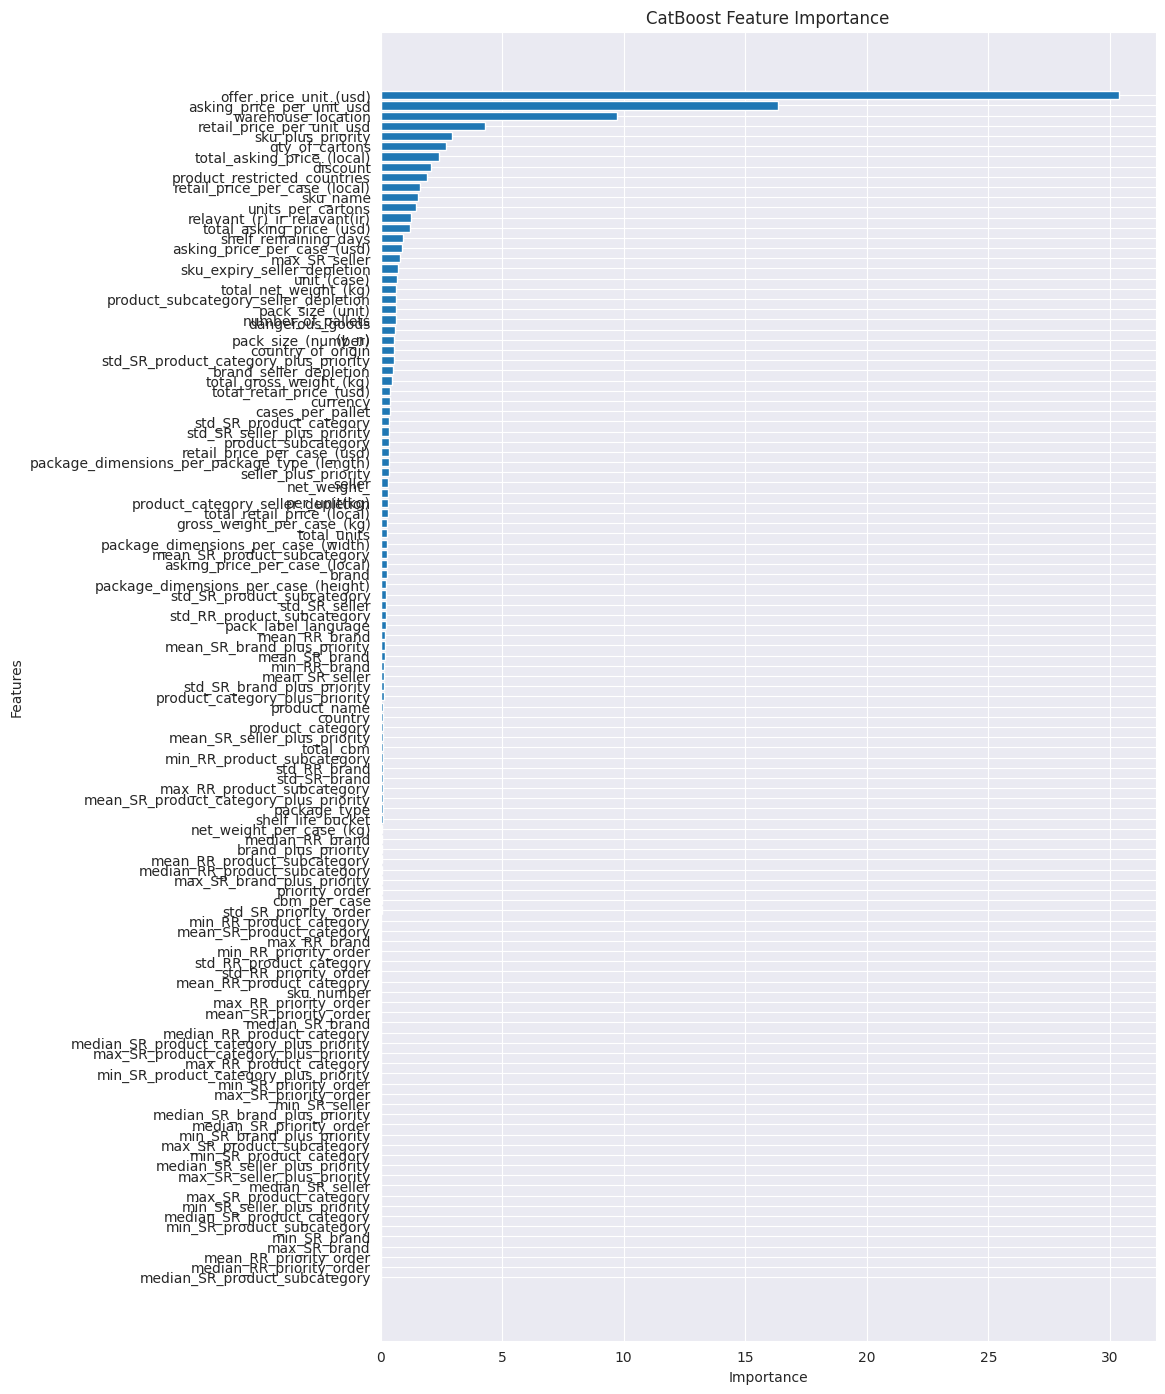

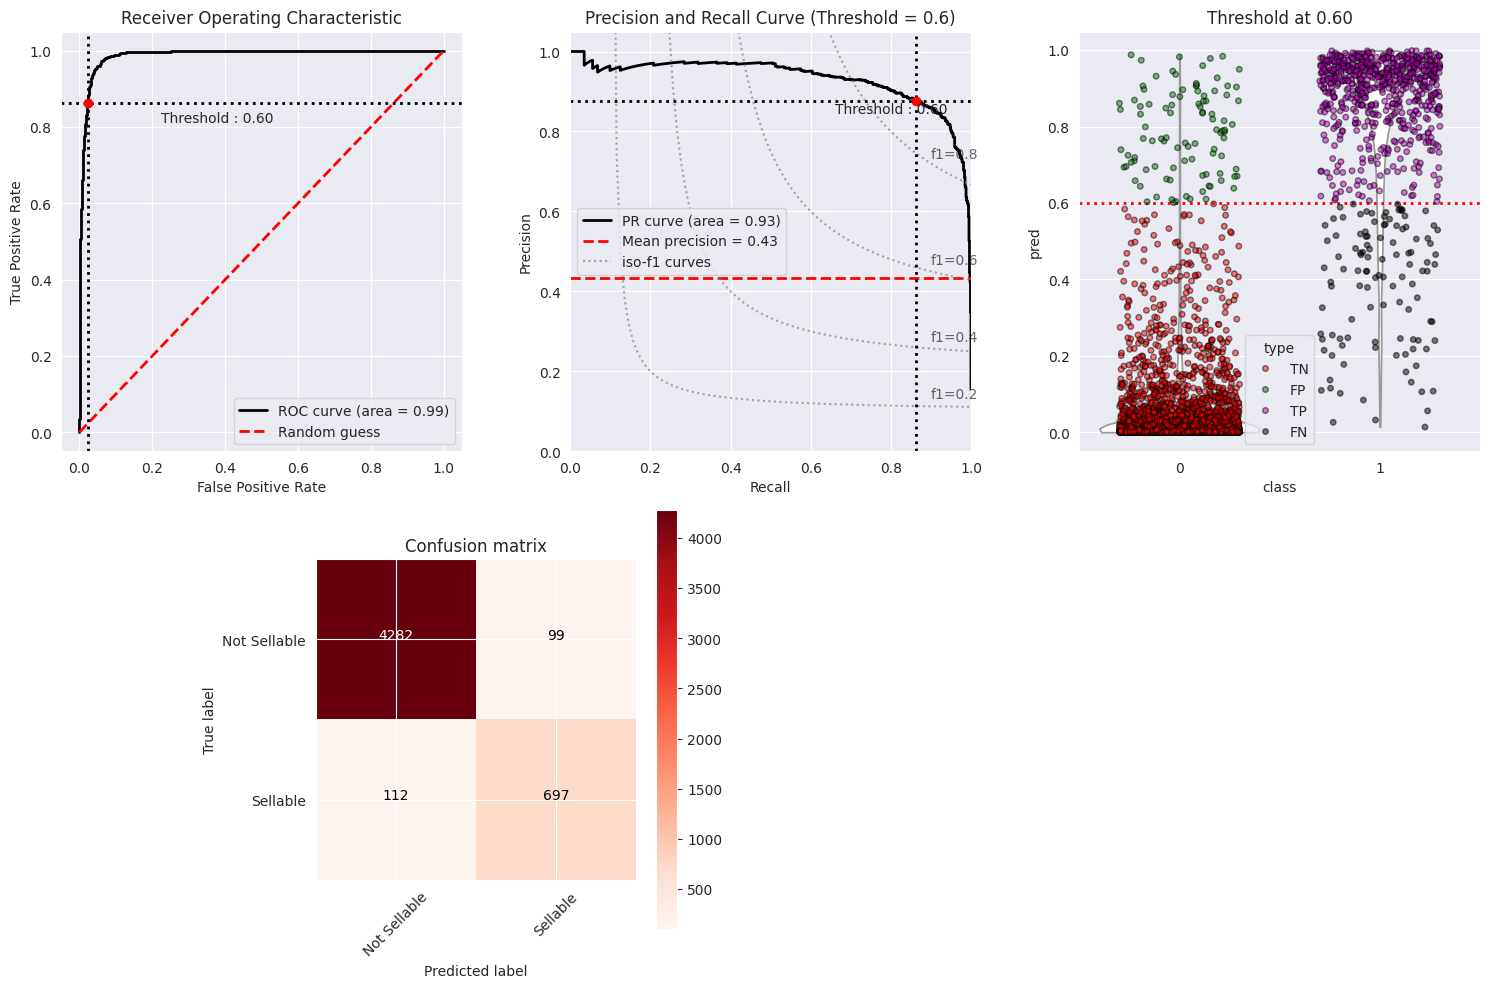

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

Not Sellable       0.97      0.98      0.98      4381
    Sellable       0.88      0.86      0.87       809

    accuracy                           0.96      5190
   macro avg       0.93      0.92      0.92      5190
weighted avg       0.96      0.96      0.96      5190



In [ ]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_cols,
    weight = np.where(X_train['total_asking_price_(usd)'] > 1000, 2, 1)
)

eval_data = Pool(
    data = X_val,
    label = y_val,
    cat_features = cat_cols,
    weight = np.where(X_val['total_asking_price_(usd)'] > 1000, 2, 1)
)

listing_model_params = {'loss_function': 'Logloss',
          'od_wait' : 100,
          'learning_rate': 0.2,
          'colsample_bylevel': 0.6,
          'depth': 4,
          'min_data_in_leaf': 35,
          'subsample': 0.6,
          'custom_metric' : 'AUC:hints=skip_train~false'}

model = CatBoostClassifier(**listing_model_params, iterations = 500, eval_metric = 'Precision', random_state = 7, auto_class_weights = 'Balanced')
model.fit(X=train_data, eval_set=eval_data)
pred_probs = model.predict_proba(X_val.values)
feature_importances = plot_feature_importances(model, X_train)
plot_mterics_report(y_val, pred_probs, t = THRESHOLD)

In [ ]:
#  filter date for train
n_days_before_date

Timestamp('2024-10-21 00:00:00')

In [ ]:
# def get_discounted_price(retail_price):
#   test_prices = []
#   for i in range(1,5):
#     test_prices.append(retail_price * i*0.2)
#   return test_prices

In [ ]:
# X_val['test_price_usd'] = X_val['retail_price_per_unit_usd'].apply(get_discounted_price)\
# X_val = X_val.explode('test_price_usd')
# X_val['offer_price_unit_(usd)'] = X_val['test_price_usd']
# X_val = X_val.drop('test_price_usd', axis = 1)

In [ ]:
# x = model.predict_proba(X_val.values)

In [ ]:
# x[:,1]

In [ ]:
# def dump_files_for_inference_pipeline():
#   print('Dumping files for inference later ...')
#   joblib.dump(feat_to_RR_stats_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/feat_to_RR_stats_mapping.pkl')
#   joblib.dump(feat_to_SR_stats_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/feat_to_SR_stats_mapping.pkl')
#   joblib.dump(final_train_cols, '/content/drive/MyDrive/PSI_Modeling_Data/final_train_cols.pkl')
#   joblib.dump(X_train, '/content/drive/MyDrive/PSI_Modeling_Data/X_train.pkl')
#   joblib.dump(X_val, '/content/drive/MyDrive/PSI_Modeling_Data/X_val.pkl')
#   joblib.dump(y_train, '/content/drive/MyDrive/PSI_Modeling_Data/y_train.pkl')
#   joblib.dump(y_val, '/content/drive/MyDrive/PSI_Modeling_Data/y_val.pkl')
#   joblib.dump(train_sku_number_list, '/content/drive/MyDrive/PSI_Modeling_Data/train_sku_number_list.pkl')
#   joblib.dump(train_brand_list, '/content/drive/MyDrive/PSI_Modeling_Data/train_brand_list.pkl')
#   joblib.dump(train_product_category_list, '/content/drive/MyDrive/PSI_Modeling_Data/train_product_category_list.pkl')
#   joblib.dump(train_product_sub_category_list, '/content/drive/MyDrive/PSI_Modeling_Data/train_product_sub_category_list.pkl')
#   joblib.dump(model, '/content/drive/MyDrive/PSI_Modeling_Data/model.pkl')
#   joblib.dump(n_days_before_date, '/content/drive/MyDrive/PSI_Modeling_Data/sellability_model_train_filter_date.pkl')
#   joblib.dump(THRESHOLD, '/content/drive/MyDrive/PSI_Modeling_Data/THRESHOLD.pkl')
#   joblib.dump(df_record, '/content/drive/MyDrive/PSI_Modeling_Data/df_record.pkl')
#   joblib.dump(sku_number_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/sku_number_mapping.pkl')
#   joblib.dump(brand_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/brand_mapping.pkl')
#   joblib.dump(product_category_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/product_category_mapping.pkl')
#   joblib.dump(product_subcategory_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/product_subcategory_mapping.pkl')
#   joblib.dump(currency_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/currency_mapping.pkl')
#   joblib.dump(brand_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/brand_seller_depletion.pkl')
#   joblib.dump(product_category_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/product_category_seller_depletion.pkl')
#   joblib.dump(product_subcategory_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/product_subcategory_seller_depletion.pkl')
#   joblib.dump(sku_expiry_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/sku_expiry_seller_depletion.pkl')
#   joblib.dump(record_attributes, '/content/drive/MyDrive/PSI_Modeling_Data/record_attributes.pkl')

In [ ]:
# dump_files_for_inference_pipeline()

In [ ]:
# def dump_files_for_inference_pipeline_price_points():
#   print('Dumping files for price points inference later ...')
#   joblib.dump(feat_to_RR_stats_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/feat_to_RR_stats_mapping.pkl')
#   joblib.dump(feat_to_SR_stats_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/feat_to_SR_stats_mapping.pkl')
#   joblib.dump(final_train_cols, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/final_train_cols.pkl')
#   joblib.dump(X_train, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/X_train.pkl')
#   joblib.dump(X_val, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/X_val.pkl')
#   joblib.dump(y_train, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/y_train.pkl')
#   joblib.dump(y_val, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/y_val.pkl')
#   joblib.dump(train_sku_number_list, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_sku_number_list.pkl')
#   joblib.dump(train_brand_list, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_brand_list.pkl')
#   joblib.dump(train_product_category_list, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_product_category_list.pkl')
#   joblib.dump(train_product_sub_category_list, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_product_sub_category_list.pkl')
#   joblib.dump(model, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/model.pkl')
#   joblib.dump(n_days_before_date, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sellability_model_train_filter_date.pkl')
#   joblib.dump(THRESHOLD, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/THRESHOLD.pkl')
#   joblib.dump(df_record, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/df_record.pkl')
#   joblib.dump(sku_number_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sku_number_mapping.pkl')
#   joblib.dump(brand_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/brand_mapping.pkl')
#   joblib.dump(product_category_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_category_mapping.pkl')
#   joblib.dump(product_subcategory_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_subcategory_mapping.pkl')
#   joblib.dump(currency_mapping, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/currency_mapping.pkl')
#   joblib.dump(brand_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/brand_seller_depletion.pkl')
#   joblib.dump(product_category_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_category_seller_depletion.pkl')
#   joblib.dump(product_subcategory_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_subcategory_seller_depletion.pkl')
#   joblib.dump(sku_expiry_seller_depletion, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sku_expiry_seller_depletion.pkl')
#   joblib.dump(record_attributes, '/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/record_attributes.pkl')

In [ ]:
# dump_files_for_inference_pipeline_price_points()